In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import mne
from meegkit import dss

In [2]:
def plot_eeg(mne_raw,pick='all',ax=None):
    if ax==None:
        fig,ax=plt.subplots()
        show=True
    if pick=='all':
        pick = mne_raw.ch_names
    for ch in pick:
        ax.plot(mne_raw.times,mne_raw.get_data(picks=ch).flatten(),label=ch)
    plt.legend()
    if show==True:
        plt.show()
    return

In [3]:
df = pd.read_csv('./dogos-quest-main/quest_eeg/060924-1700/Explore_84CF_ExG_ExG_stream_3.csv')
ts = np.array(df["Timestamps"])

mrk = pd.read_csv('./dogos-quest-main/quest_eeg/060924-1700/Explore_84CF_Marker_Markers_stream_1.csv')
num_events = len(mrk)
seg_len = 10

##Assuming the channels are in the order Fz, Cz, T3, T4, P3, P4, Fp1, Fp2
fz = np.array(df["Ch_1"])
cz = np.array(df["Ch_2"])
t3 = np.array(df["Ch_3"])
t4 = np.array(df["Ch_4"])
p3 = np.array(df["Ch_5"])
p4 = np.array(df["Ch_6"])

raw_np = np.array([fz,cz,t3,t4,p3,p4])/1000 #mne stores data in volts
ch_names = ['Fz','Cz','T3','T4','P3','P4']

Effective window size : 0.256 (s)


/tmp/ipykernel_202953/3612346931.py:13: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()


<IPython.core.display.Javascript object>


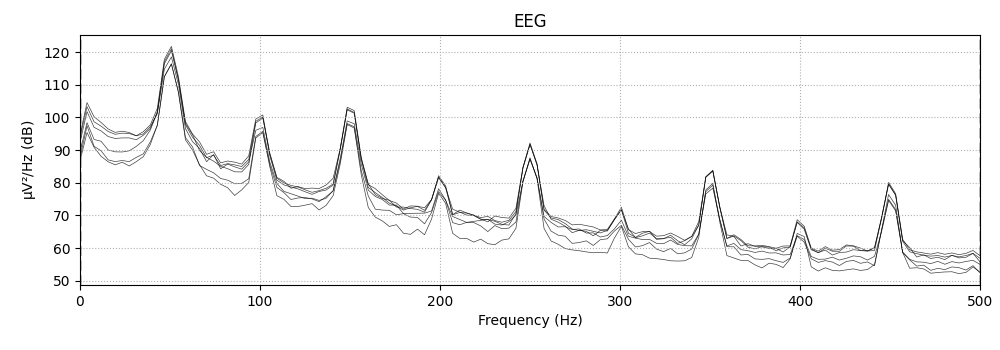

<IPython.core.display.Javascript object>


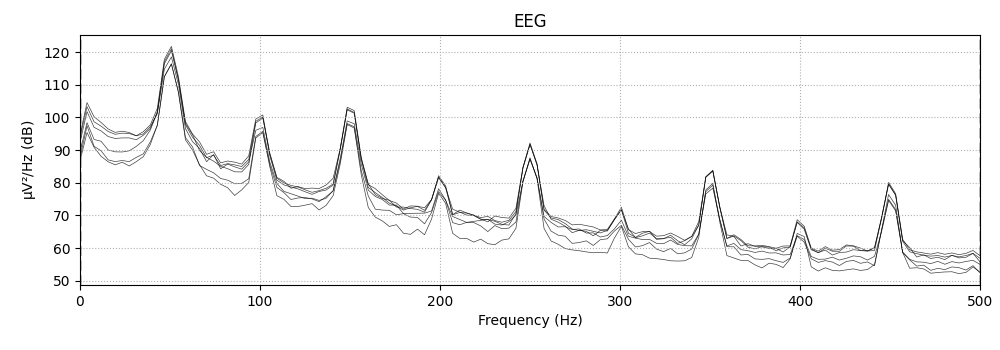

In [4]:
sfreq = 1000
info = mne.create_info(ch_names,ch_types=['eeg']*len(ch_names),sfreq=sfreq,verbose=False)
raw = mne.io.RawArray(raw_np,info,verbose=False) 
raw.set_meas_date(ts[0])

annot = mne.Annotations(
    onset=mrk["Timestamps"].to_numpy()-ts[0],
    duration=[seg_len]*num_events,
    description=mrk["Ch_1"].to_list(),
    orig_time = ts[0])
raw.set_annotations(annot,verbose=False)

raw.compute_psd().plot()

In [5]:
# plot_eeg(raw)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 165 samples (0.165 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s finished


Power of components removed by DSS: 0.02
Iteration 0 score: 0.13598065534739395
Power of components removed by DSS: 0.02
Iteration 1 score: 0.1170517301572874
Power of components removed by DSS: 0.01
Iteration 2 score: 0.1120124738808931
Power of components removed by DSS: 0.06
Iteration 3 score: 0.04692609130803903
Power of components removed by DSS: 0.18
Iteration 4 score: -0.14318231100600268
Effective window size : 1.000 (s)


/tmp/ipykernel_202953/581474386.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_crop.compute_psd().plot()


<IPython.core.display.Javascript object>


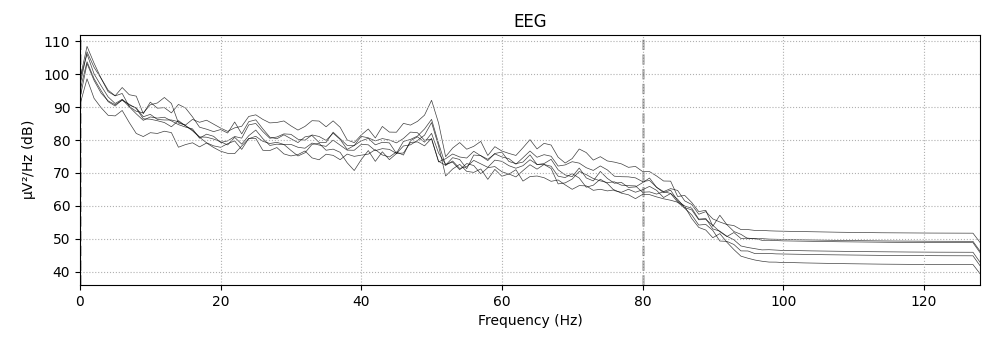

<IPython.core.display.Javascript object>


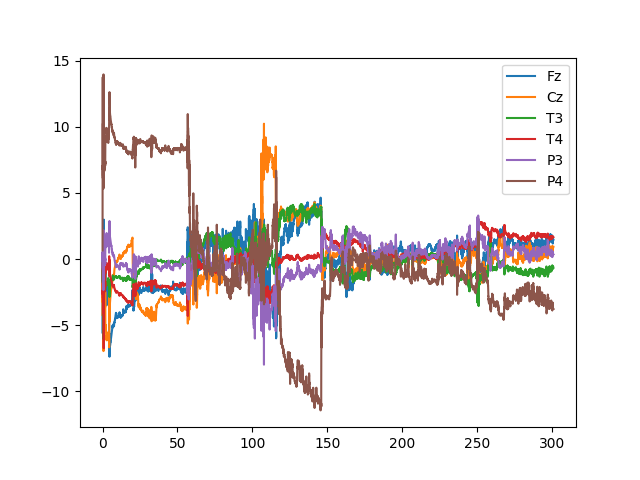

In [6]:
raw_crop = raw.copy().crop(tmax=301)
raw_crop.set_eeg_reference(ref_channels='average')
raw_crop.filter(None,80)

data = raw_crop.get_data()
clean, artifact = dss.dss_line_iter(data.T, fline=51, sfreq=1000, nfft=800)
raw_crop._data = clean.T
raw_crop.resample(sfreq=256,verbose=False)

raw_crop.compute_psd().plot()
plot_eeg(raw_crop)

# eeg = raw_crop.resample(sfreq=250,verbose=False)


Used Annotations descriptions: ['sw_1']
Not setting metadata
7 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 7 events and 513 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/tmp/ipykernel_202953/1661370897.py:10: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.compute_psd().plot()


<IPython.core.display.Javascript object>


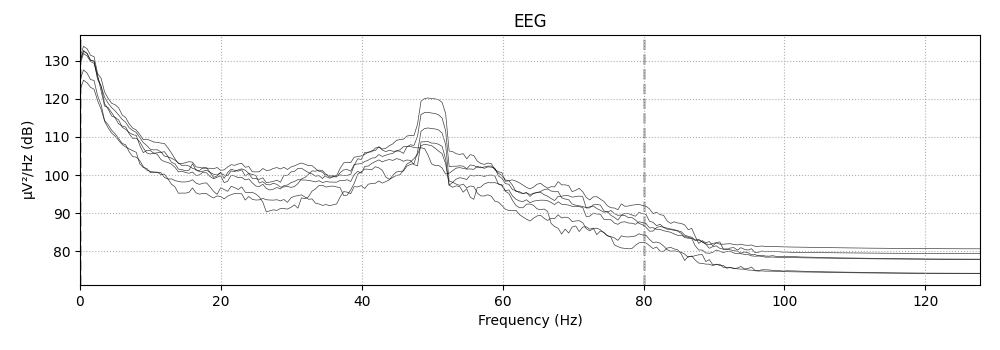

<IPython.core.display.Javascript object>


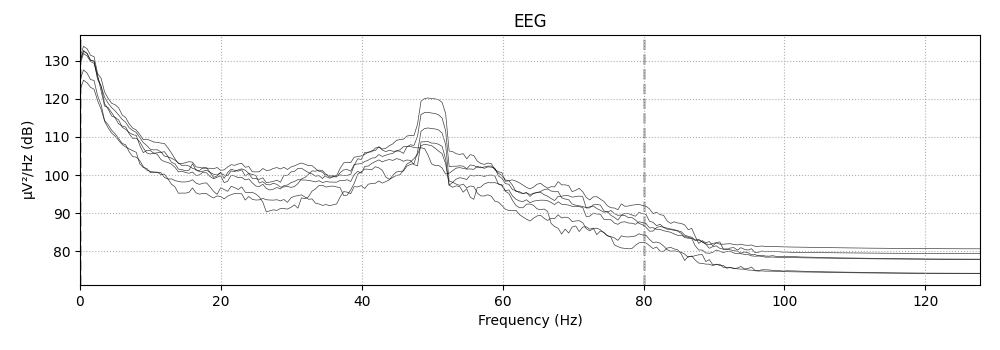

In [7]:
event_dict = mne.events_from_annotations(raw_crop)
epochs = mne.Epochs(raw_crop,event_dict[0],tmin=-1, tmax=1)

# data = epochs.get_data()
# np.shape(data.T) 
# clean, artifact = dss.dss_line_iter(data.T, fline=51, sfreq=1000, nfft=800)
# np.shape(clean)
# epochs._data = clean.T
# epochs.decimate(4)
epochs.compute_psd().plot()
#Plot epochs to see why we are rejecting the second one

In [8]:
# len(epochs)
reject_mask = [False] * len(epochs)
reject_mask[1] = True
epochs.drop(reject_mask)
# epochs.plot()

Dropped 1 epoch: 1


Number of events,6
Events,1: 6
Time range,-1.000 – 1.000 sec
Baseline,-1.000 – 0.000 sec


Using data from preloaded Raw for 6 events and 513 original time points ...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_202953/21898579.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=ch_name)


<IPython.core.display.Javascript object>


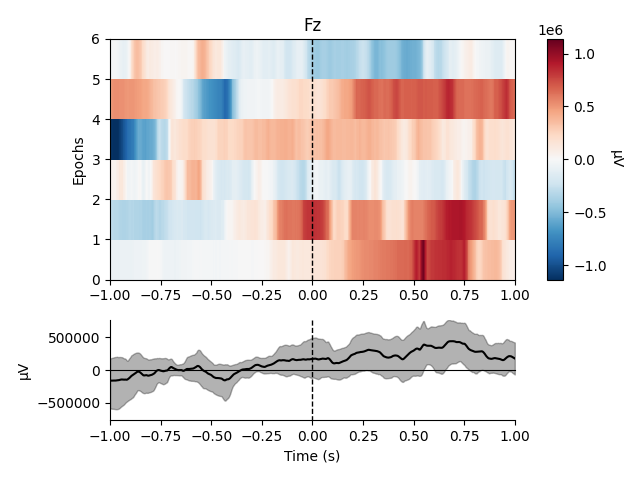

Using data from preloaded Raw for 6 events and 513 original time points ...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_202953/21898579.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=ch_name)


<IPython.core.display.Javascript object>


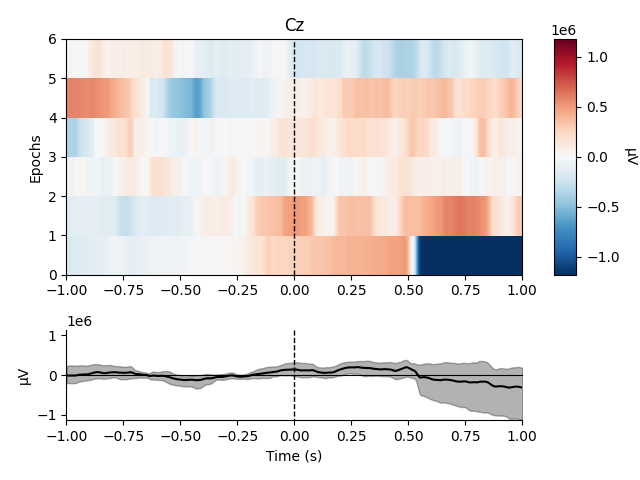

Using data from preloaded Raw for 6 events and 513 original time points ...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_202953/21898579.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=ch_name)


<IPython.core.display.Javascript object>


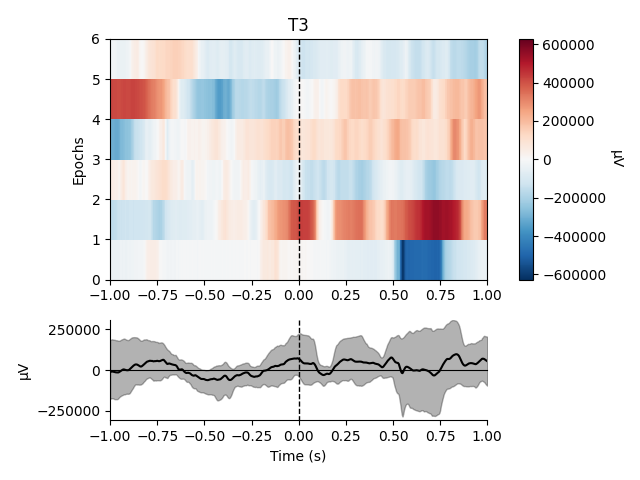

Using data from preloaded Raw for 6 events and 513 original time points ...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_202953/21898579.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=ch_name)


<IPython.core.display.Javascript object>


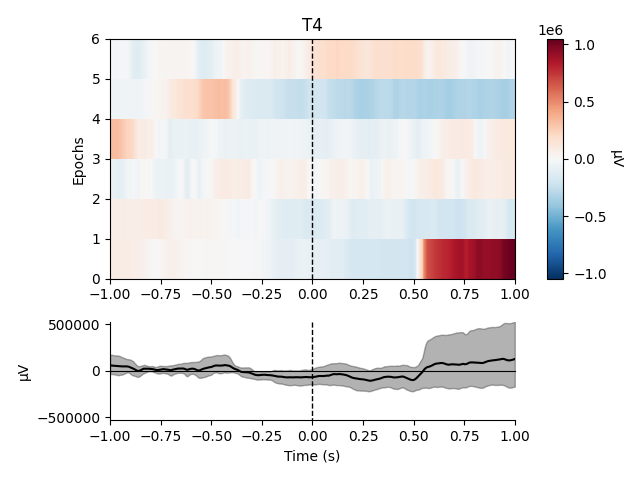

Using data from preloaded Raw for 6 events and 513 original time points ...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_202953/21898579.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=ch_name)


<IPython.core.display.Javascript object>


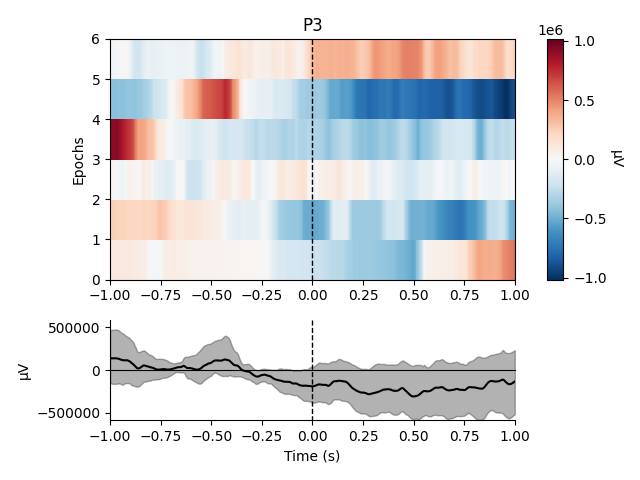

Using data from preloaded Raw for 6 events and 513 original time points ...
Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_202953/21898579.py:13: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=ch_name)


<IPython.core.display.Javascript object>


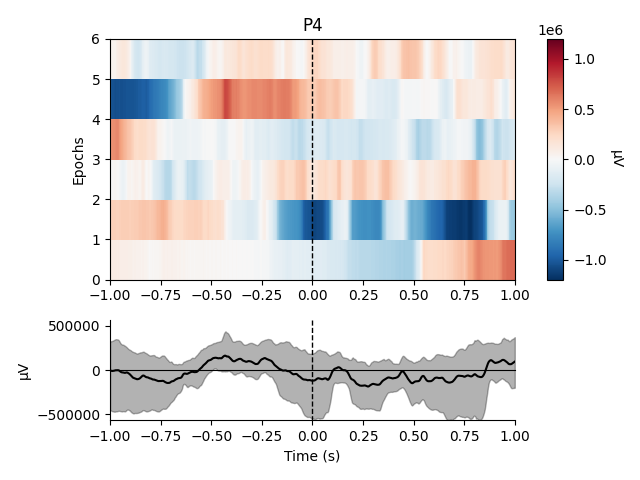

In [11]:
# data = epochs.get_data(picks='all')

# fig,ax = plt.subplots()

# for ep in range(data.shape[0]):
#     for ch_id,ch_name in enumerate(epochs.ch_names):
#         ax.plot(epochs.times,data[ep][ch_id],label=['Epoch:'+str(ep)+' - '+ch_name])

# plt.legend()
# plt.show()

for ch_id,ch_name in enumerate(epochs.ch_names):
    epochs.plot_image(picks=ch_name)

# epochs.plot_image(picks='Fz')

In [10]:
dir(epochs)
# epochs.plot_image()

['__class__',
 '__contains__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotations',
 '_bad_dropped',
 '_channel_type_idx',
 '_check_consistency',
 '_check_metadata',
 '_compute_aggregate',
 '_current',
 '_data',
 '_decim',
 '_decim_slice',
 '_detrend_offset_decim',
 '_detrend_picks',
 '_do_baseline',
 '_do_delayed_proj',
 '_evoked_from_epoch_data',
 '_filename',
 '_get_channel_positions',
 '_get_data',
 '_get_epoch_from_raw',
 '_getitem',
 '_handle_tmin_tmax',
 '_is_good_epoch',
 '_item_to_select',
 '_keys_to_idx',
 '_metadata',
 '_name',
 '_offset',
 '_pick_drop_channels',
 '_pick_projs',
 '_project_e